In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import glob
import cv2
import tensorflow as tf
from PIL import Image
from pathlib import Path
from google.colab import drive
from sklearn.model_selection import train_test_split, StratifiedKFold
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.applications import VGG16
from keras.layers import Flatten, Dense
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing import image


In [2]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
DIR_PATH = '/content/gdrive/MyDrive/tumor_classification/Training'

FOLDER_PATH = Path(DIR_PATH)

file_paths = list(FOLDER_PATH.glob('**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], file_paths))

file_paths = pd.Series(file_paths, name='Paths').astype(str)
labels = pd.Series(labels, name='Labels')

df = pd.concat([file_paths, labels], axis=1)

df

,Paths,Labels
0,/content/gdrive/MyDrive/tumor_classification/T...,pituitary_tumor
1,/content/gdrive/MyDrive/tumor_classification/T...,pituitary_tumor
2,/content/gdrive/MyDrive/tumor_classification/T...,pituitary_tumor
3,/content/gdrive/MyDrive/tumor_classification/T...,pituitary_tumor
4,/content/gdrive/MyDrive/tumor_classification/T...,pituitary_tumor
...,...,...
2865,/content/gdrive/MyDrive/tumor_classification/T...,glioma_tumor
2866,/content/gdrive/MyDrive/tumor_classification/T...,glioma_tumor
2867,/content/gdrive/MyDrive/tumor_classification/T...,glioma_tumor
2868,/content/gdrive/MyDrive/tumor_classification/T...,glioma_tumor


In [4]:
TEST_DIR_PATH = '/content/gdrive/MyDrive/tumor_classification/Testing'

TEST_FOLDER_PATH = Path(TEST_DIR_PATH)

test_file_paths = list(TEST_FOLDER_PATH.glob('**/*.jpg'))

test_labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], test_file_paths))

test_file_paths = pd.Series(test_file_paths, name='Paths').astype(str)
test_labels = pd.Series(test_labels, name='Labels')

test_df = pd.concat([test_file_paths, test_labels], axis=1)

test_df

,Paths,Labels
0,/content/gdrive/MyDrive/tumor_classification/T...,no_tumor
1,/content/gdrive/MyDrive/tumor_classification/T...,no_tumor
2,/content/gdrive/MyDrive/tumor_classification/T...,no_tumor
3,/content/gdrive/MyDrive/tumor_classification/T...,no_tumor
4,/content/gdrive/MyDrive/tumor_classification/T...,no_tumor
...,...,...
389,/content/gdrive/MyDrive/tumor_classification/T...,glioma_tumor
390,/content/gdrive/MyDrive/tumor_classification/T...,glioma_tumor
391,/content/gdrive/MyDrive/tumor_classification/T...,glioma_tumor
392,/content/gdrive/MyDrive/tumor_classification/T...,glioma_tumor


In [5]:
percentage_of_test_df = round(len(test_df) / len(df) * 100, 2)

print(f"% of Test Data: {percentage_of_test_df}%")

% of Test Data: 13.73%


In [6]:
df['Labels'].value_counts()

Labels
pituitary_tumor     827
glioma_tumor        826
meningioma_tumor    822
no_tumor            395
Name: count, dtype: int64

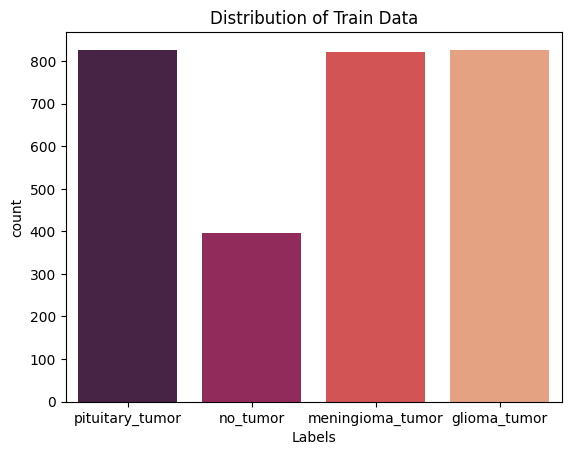

In [7]:
plt.title('Distribution of Train Data')
sns.countplot(data=df, x=df['Labels'], hue=df['Labels'], palette='rocket')

plt.show()

In [8]:
test_df['Labels'].value_counts()

Labels
meningioma_tumor    115
no_tumor            105
glioma_tumor        100
pituitary_tumor      74
Name: count, dtype: int64

<Axes: xlabel='Labels', ylabel='count'>

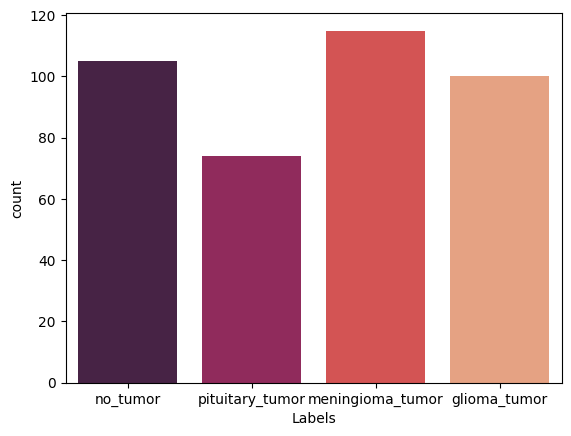

In [9]:
sns.countplot(data=test_df, x=test_df['Labels'], hue=test_df['Labels'], palette='rocket')

In [10]:
def create_model():
  base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224, 3))
  x = base_model.output
  x = Flatten()(x)
  x = Dense(1024, activation='relu')(x)
  predictions = Dense(4, activation='softmax')(x)
  model = Model(inputs=base_model.input, outputs=predictions)

  for layer in base_model.layers:
    layer.trainable = False

  model.compile(
    optimizer='Adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

  return model

In [11]:
datagen = ImageDataGenerator(rescale=1./255)

skf = StratifiedKFold(n_splits=5)

for fold, (train_idx, val_idx) in enumerate(skf.split(df['Paths'], df['Labels']), start=1):
  train_df = df.iloc[train_idx]
  val_df = df.iloc[val_idx]

  train_generator = datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='Paths',
        y_col='Labels',
        target_size=(224, 224),
        class_mode='sparse',
        batch_size=32,
        shuffle=True
    )

  val_generator = datagen.flow_from_dataframe(
        dataframe=val_df,
        x_col='Paths',
        y_col='Labels',
        target_size=(224, 224),
        class_mode='sparse',
        batch_size=32,
        shuffle=True
    )
  model = create_model()

  model.fit(train_generator, validation_data=val_generator, epochs=10)

  val_loss, val_accuracy = model.evaluate(val_generator)
  print(f"Fold {fold} Validation Accuracy: {val_accuracy}")

Found 2296 validated image filenames belonging to 4 classes.
Found 574 validated image filenames belonging to 4 classes.
Epoch 1/10
72/72 [==============================] - 1718s 24s/step - loss: 1.9356 - accuracy: 0.6768 - val_loss: 0.4124 - val_accuracy: 0.8467
Epoch 2/10
72/72 [==============================] - 16s 221ms/step - loss: 0.2458 - accuracy: 0.9085 - val_loss: 0.3563 - val_accuracy: 0.8502
Epoch 3/10
72/72 [==============================] - 16s 217ms/step - loss: 0.3438 - accuracy: 0.8789 - val_loss: 0.4930 - val_accuracy: 0.8432
Epoch 4/10
72/72 [==============================] - 16s 225ms/step - loss: 0.1132 - accuracy: 0.9578 - val_loss: 0.2851 - val_accuracy: 0.8990
Epoch 5/10
72/72 [==============================] - 16s 214ms/step - loss: 0.0580 - accuracy: 0.9817 - val_loss: 0.3588 - val_accuracy: 0.8676
Epoch 6/10
72/72 [==============================] - 18s 250ms/step - loss: 0.0379 - accuracy: 0.9891 - val_loss: 0.2733 - val_accuracy: 0.8972
Epoch 7/10
72/72 [===

In [18]:
test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Paths',
    y_col='Labels',
    target_size=(224, 224),
    class_mode='sparse',
    batch_size=32,
    shuffle=False
)

y_pred_test = np.argmax(model.predict(test_generator), axis=-1)

label_encoder = LabelEncoder()
true_labels = label_encoder.fit_transform(test_df['Labels'])

Found 394 validated image filenames belonging to 4 classes.
13/13 [==============================] - 3s 210ms/step


In [19]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy}")

13/13 [==============================] - 2s 175ms/step - loss: 3.0036 - accuracy: 0.7513
Test Accuracy: 0.7512690424919128


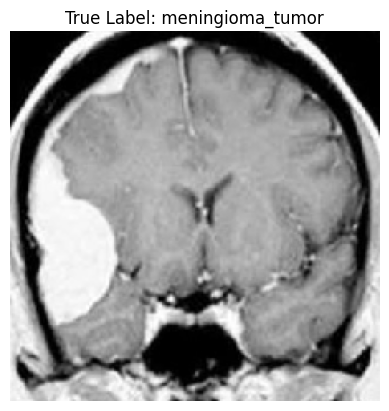

1/1 [==============================] - 0s 33ms/step
Predicted Label: meningioma_tumor


In [25]:
def show_random_img():

  random_index = random.randint(0, len(test_df) - 1)
  random_image_path = test_df.iloc[random_index]['Paths']
  true_label = test_df.iloc[random_index]['Labels']

  img = image.load_img(random_image_path, target_size=(224, 224))
  plt.imshow(img)
  plt.axis('off')
  plt.title(f'True Label: {true_label}')
  plt.show()

  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img /= 255.0

  prediction = model.predict(img)
  predicted_label = label_encoder.classes_[np.argmax(prediction)]

  print(f'Predicted Label: {predicted_label}')


show_random_img()

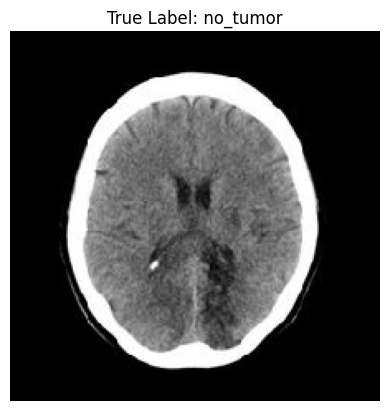

1/1 [==============================] - 0s 21ms/step
Predicted Label: no_tumor


In [27]:
show_random_img()